In [1]:
import ROOT
import pandas as pd
import numpy as np
import seaborn as sns
import re
from utils import to_data_frame
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.30/02


In [2]:
def get_run_header_num(str_line):
    res =  re.search(r"NR[\s]*([0-9]*)\s.*", str_line)
    if res == None:
        return -1
    return int(res.group(1))

def check_if_global(str_line):
    return re.search(r"-g-", str_line) != None
    
def check_if_header(str_line):
    return re.search(r"meas\.", str_line) != None

def check_if_data_line(str_line):
    return re.search(r"(local|global)", str_line) != None
    
def get_measurement(header_line):
    res = re.search(r"-(l|g)- meas\.\s*[0-9\.]*\s[0-9\.]*\s[0-9\.]*\s[0-9\.]*\s([-\d\.]*)\s([-\d\.]*)", header_line)
    return res.group(1), float(res.group(2)), float(res.group(3))

def get_par_values(data_line_str):
    res = re.search(r"(local|global)\s*\[([-\d\.]*)\, ([-\d\.]*)\]", data_line_str)
    return float(res.group(2)), float(res.group(3))

In [3]:
def PlotDF(dataframe):
    sns.scatterplot(data = dataframe, x = "factors", y = "measures", hue = "labels", palette = {"l":"red", "g":"blue"}, style = "version")
    dataframe_l = dataframe[dataframe.labels == "l"]
    dataframe_g = dataframe[dataframe.labels == "g"]
    plt.errorbar(x = dataframe_l["factors"], y = dataframe_l["measures"], yerr = dataframe_l["errors"], linestyle = "", capsize = 4, ecolor = "red")
    plt.errorbar(x = dataframe_g["factors"], y = dataframe_g["measures"], yerr = dataframe_g["errors"], linestyle = "", capsize = 4, ecolor = "blue")
    plt.xlabel("z (cm)")
    plt.ylabel("x_or_y (cm)")

In [4]:
# filename = "/lustre/r3b/ywang/calibration/s515/run49x/millepede/cal.par.root"
filename = "/lustre/r3b/ywang/exp202402/prebeam/millepede2/cal.par.root"
root_file = ROOT.TFile(filename, "read")
data_frame_pede = to_data_frame(root_file, 0)
data_frame_hist = to_data_frame(root_file, -1)

size of module pars: 1300
size of module pars: 1300


In [26]:
par_reference = data_frame_hist

def fill_entry(datafile, output_data_frame, par_data_frame):
    header = datafile.readline()
    bar_number = np.nan
    if not check_if_header(header):
        return False
    gl_label, meas, error = get_measurement(header)
    local_a_id, local_b_id = get_par_values(datafile.readline())
    a_factor, _ = get_par_values(datafile.readline())
    if(gl_label == "g"):
        gct_id, gc_id = get_par_values(datafile.readline())
        gct_factor, gc_factor = get_par_values(datafile.readline())
        gc = par_data_frame.loc[gct_id - 1, "effective_speed"]
        gct = gc * par_data_frame.loc[gct_id - 1, "t_diff"] / 100.
        gc_ref = par_reference.loc[gct_id - 1, "effective_speed"]
        gct_ref = gc * par_reference.loc[gct_id - 1, "t_diff"] / 100.
        meas = meas - gct_factor * (gct - gct_ref)  +  (gc - gc_ref) * gc_factor 
        bar_number = gct_id

    if local_a_id == 1 and local_b_id == 3:
        output_data_frame["x"]["factors"].append(a_factor)
        output_data_frame["x"]["measures"].append(meas)
        output_data_frame["x"]["errors"].append(error)
        output_data_frame["x"]["bar_num"].append(bar_number)
        output_data_frame["x"]["labels"].append(gl_label)
    else:
        output_data_frame["y"]["factors"].append(a_factor)
        output_data_frame["y"]["measures"].append(meas)
        output_data_frame["y"]["errors"].append(error)
        output_data_frame["y"]["bar_num"].append(bar_number)
        output_data_frame["y"]["labels"].append(gl_label)
    
    return True
            
def go_to_run_number(run_number, datafile):
    while (str_line := datafile.readline()) != None:
        if(get_run_header_num(str_line) >= run_number):
            return

filename = "/lustre/r3b/ywang/exp202402/prebeam/millepede2/data.txt"
def check_run(run_number, par_data_frame):
    with open(filename) as datafile:
        output_data_frame = {"x": {"bar_num": [] ,"factors": [], "measures": [], "errors": [], "labels": []}, 
                             "y": {"bar_num": [] ,"factors": [], "measures": [], "errors": [], "labels": []}}
        go_to_run_number(run_number, datafile)
        while fill_entry(datafile, output_data_frame, par_data_frame):
            pass
        return pd.DataFrame(output_data_frame["x"]), pd.DataFrame(output_data_frame["y"])

run_number = 150
dataframe_x_old, dataframe_y_old = check_run(run_number, data_frame_hist)
dataframe_x_new, dataframe_y_new = check_run(run_number, data_frame_pede)
dataframe_x_old["version"] = "old"
dataframe_y_old["version"] = "old"
dataframe_x_new["version"] = "new"
dataframe_y_new["version"] = "new"
dataframe_x = pd.concat([dataframe_x_old, dataframe_x_new], ignore_index = True)
dataframe_y = pd.concat([dataframe_y_old, dataframe_y_new], ignore_index = True)

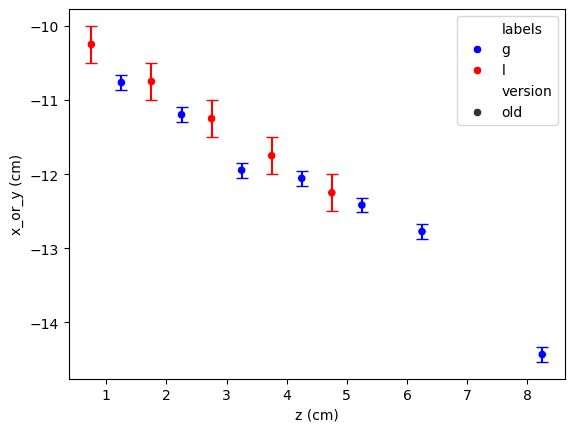

In [27]:
PlotDF(dataframe_x[dataframe_x["version"] == "old"])

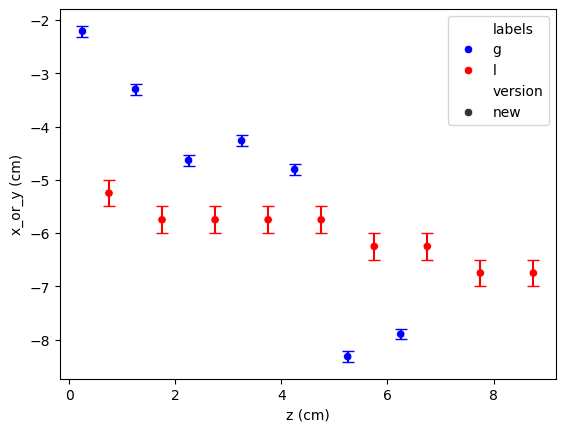

In [25]:
PlotDF(dataframe_x[dataframe_x["version"] == "new"])

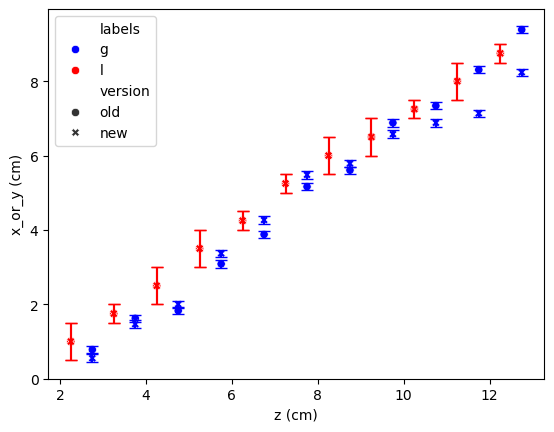

In [20]:
PlotDF(dataframe_y)

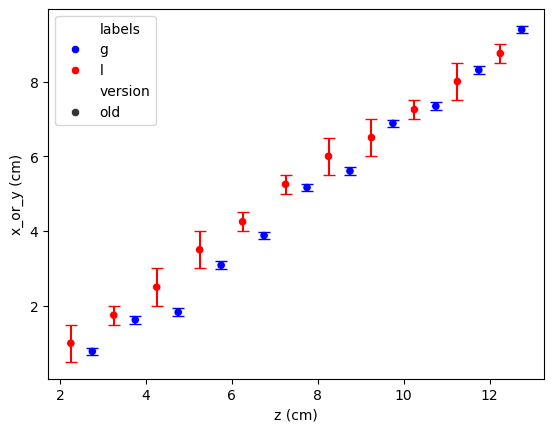

In [21]:
PlotDF(dataframe_y[dataframe_y["version"] == "old"])

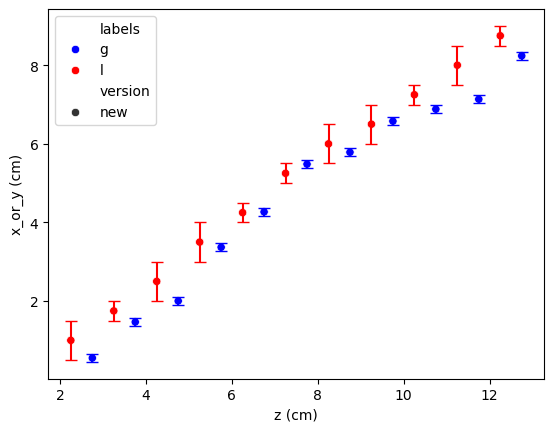

In [22]:
PlotDF(dataframe_y[dataframe_y["version"] == "new"])